In [1]:
import pickle
from dataset import *

In [1]:
!pip install vllm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 MB 35.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 10.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 165.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 102.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 19.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 8

In [3]:

# with open('results/llama-3.1i_greedy.pkl', 'rb') as f:
#     results = pickle.load(f)

In [4]:

def process_responses(results, model_name):
    prompts = [output.prompt for output in results]
    outputs = [output.outputs[0].text for output in results]
    
    responses = []
    i = 0
    for sample in tqdm(data.to_dict(orient='records')):
        for chain_of_thought in [True, False]:
            prompt = prompt_structures[sample['dataset'] + ('_cot' if chain_of_thought else '')](sample)
            output = outputs[i]
            i+= 1
            response = response_analysis(sample, output, chain_of_thought=chain_of_thought)
            response.update({
                'model': model_name,
                'prompt': prompt,
                'dataset': sample['dataset'],
                'sample_dataset_id': sample['sample_id'],
                'sample_global_id': sample['global_sample_id'],
                'label': sample['label'],
                'dispersion': sample['dispersion'],
                'padding_type': sample['padding_type'],
                'ctx_size': sample['ctx_size'],
                'chain_of_thought': chain_of_thought,
            })
            responses.append(response)
            if i > len(outputs):
                break
    responses = pd.DataFrame(responses)
    
    return responses

In [5]:
model_dict = {'Llama-3.1-8B-Instruct': 'llama-3.1i',
              'Llama-3.1-8B': 'llama-3.1',
              'AI21-Jamba-1.5-Mini': 'jamba',
              'Mistral-7B-Instruct': 'mistral'}

responses = []

for model_name, model_prefix in model_dict.items():
    with open(f'results/{model_prefix}.pkl', 'rb') as f:
        results = pickle.load(f)
    response = process_responses(results, model_name)
    responses.append(response)

responses = pd.concat(responses)

100%|██████████| 12000/12000 [00:00<00:00, 19387.95it/s]


(200.0, 3050.0)

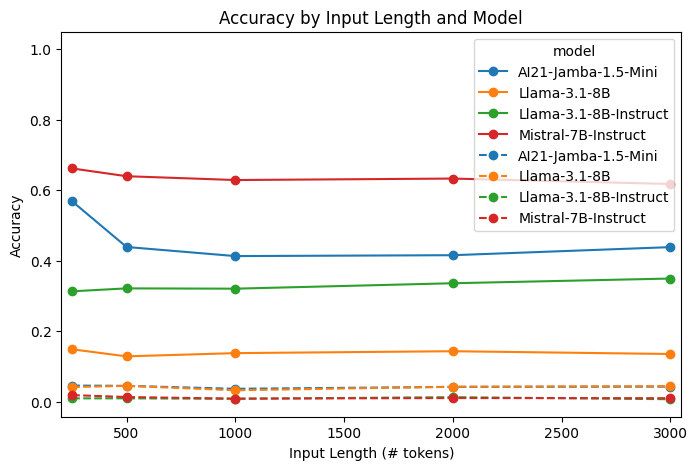

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
filtered_responses = responses# responses[(responses['padding_type'] != 'identity') & (responses['dispersion'] == 'random')]

# Non COT plot
df = filtered_responses[~filtered_responses['chain_of_thought']]
df.groupby(['ctx_size', 'model'])['correct'].mean().unstack().plot(kind='line', ax=ax, marker='o', linestyle='-')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

handles, labels = ax.get_legend_handles_labels()

# COT plot
if True in filtered_responses['chain_of_thought'].unique():
    df = filtered_responses[filtered_responses['chain_of_thought']]
    df.groupby(['ctx_size', 'model'])['correct'].mean().unstack().plot(kind='line', ax=ax, marker='o', linestyle='--', color=colors)
    faux_plot1, = ax.plot([1], marker='None', linestyle='--', color='black', label='CoT')
    faux_plot2, = ax.plot([1], marker='None', linestyle='-', color='black', label='Normal')
    handles.extend([faux_plot1, faux_plot2])
    labels.extend(['CoT', 'Normal'])

ax.set_xlabel('Input Length (# tokens)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Input Length and Model')
ax.set_xlim(200, 3050)

In [7]:
with open('results/responses_v2.pkl', 'wb') as f:
    pickle.dump(responses, f)